# Notes
* data contains normalized protein expression levels derived from peptide abundance measurements 
* predictions are for 6, 12, 24 months in the future
* confirm that all of these patients have PD
* need to account for different timestep between the visits for different patients

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### possible additional sources of data
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9245058/


In [2]:
peptides = pd.read_csv('./data/train_peptides.csv')
proteins = pd.read_csv('./data/train_proteins.csv')
clinical = pd.read_csv('./data/train_clinical_data.csv')

# Clinical data exploration
* max number of patients: 248
* most common followup is every 12 months, though some have 3 month

In [3]:
clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


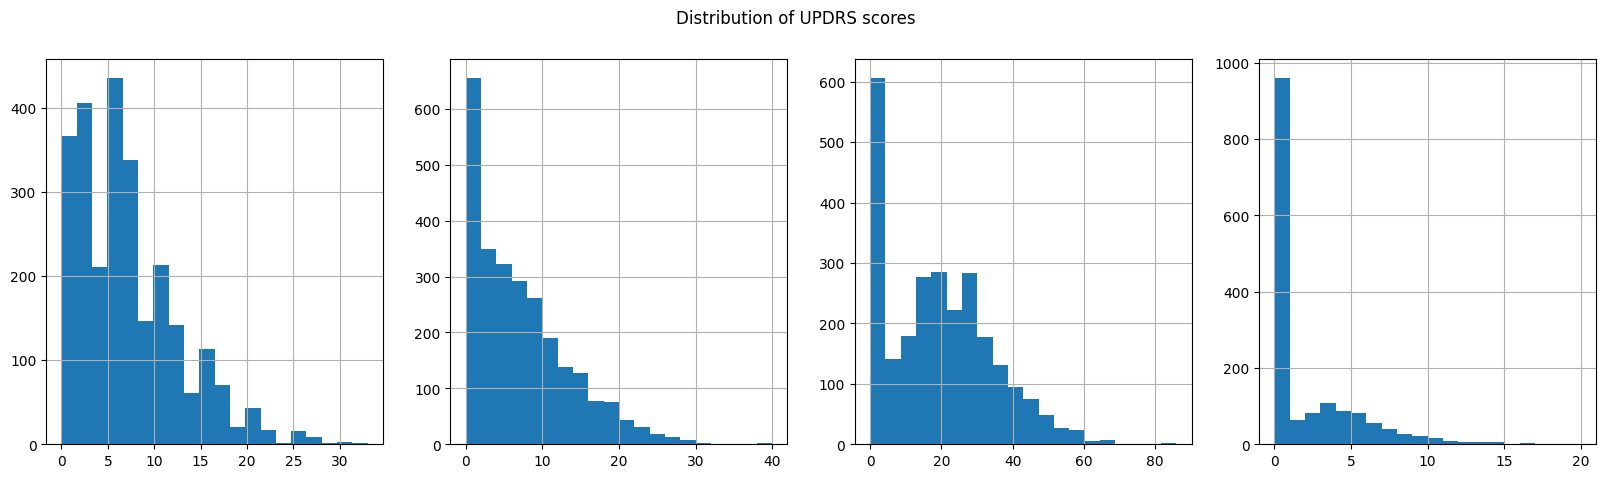

In [4]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
f.suptitle('Distribution of UPDRS scores')
for i in range(1,5):
    clinical[f'updrs_{i}'].hist(bins=20, ax=ax[i-1])

In [5]:
clin_pivot = clinical.set_index('visit_id').loc[:,'updrs_1':'updrs_4']
clin_pivot.head()

,updrs_1,updrs_2,updrs_3,updrs_4
visit_id,,,,
55_0,10.0,6.0,15.0,NaN
55_3,10.0,7.0,25.0,NaN
55_6,8.0,10.0,34.0,NaN
55_9,8.0,9.0,30.0,0.0
55_12,10.0,10.0,41.0,0.0


# Protein data exploration
* 227 unique proteins (UniProt IDs)
* are there any protein levels that don't vary much across visits for a given subject?
    * could be used for normalization
* are protein abundance measurements relative or absolute?

In [6]:
proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [7]:
prot_pivot = proteins.pivot(index='visit_id', columns='UniProt', values='NPX')
prot_pivot.head()

UniProt,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,129048.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,108114.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,163776.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,56725.0,...,557904.0,44556.90,155619.0,14647.9,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,85767.1,...,NaN,47836.70,177619.0,17061.1,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55


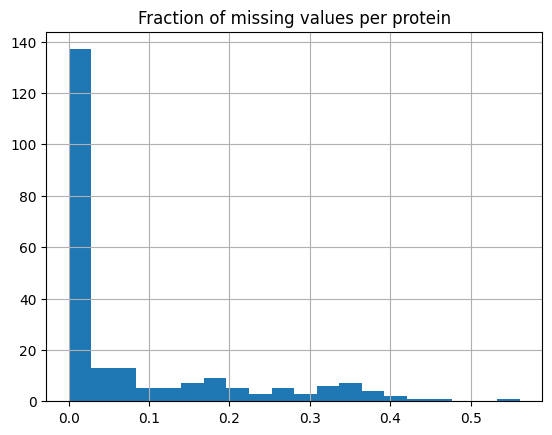

In [8]:
# investigate missing values
prot_pivot.isna().mean(axis=0).hist(bins=20)
plt.title('Fraction of missing values per protein');

# imputation
1. create boolean mask for missing values and held-out values
2. fill missing values with mean for that gene
3. fit model to predict each gene based on all other genes, then update missing values with predictions
4. evaluate imputation performance using held-out values
5. iterate until out-of-sample performance converges

ideas to try:
* does order of imputation matter? for example, impute most missing genes first?
    * minimal improvement at best
* how can the imputation take into account the subject-level information?

In [9]:
# flag to evaluate imputation performance by holding out data
imputation_eval = False

prot_imputed = prot_pivot.copy()

# mask for missing data
na_mask = prot_pivot.isna().values

if(imputation_eval):
    # mask for held-out data
    test_frac = 0.1
    rng = np.random.default_rng(83)
    test_mask = (rng.uniform(size=prot_pivot.shape) < test_frac)
    test_mask[na_mask] = False # remove overlap between test and missing data

    # save test values
    test_values = np.zeros(prot_pivot.shape)
    test_values[test_mask] = prot_pivot.values[test_mask]

    # remove test values
    prot_imputed.values[test_mask] = np.nan

    # update na_mask
    na_mask = prot_imputed.isna().values

from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

imputation_model = make_pipeline(StandardScaler(), RidgeCV(alphas=[1,10,100]))

# fill missing values with mean
prot_imputed = prot_imputed.fillna(value=prot_imputed.mean(skipna=True, axis=0)).values

if(imputation_eval):
    # calculate initial error on test set
    test_mse = [mean_squared_error(test_values[test_mask], prot_imputed[test_mask], squared=False)]
    print(f'Starting test MSE = {test_mse[-1]:.3e}')

# iteratively update missing values with imputation model
n_genes = prot_imputed.shape[1]
for i in range(2):
    for i_gene in range(n_genes):
        # fit model
        train_mask = np.arange(0,n_genes) != i_gene
        imputation_model.fit(prot_imputed[:,train_mask], prot_imputed[:,i_gene])
        
        # predict missing values
        imputed_gene_values = imputation_model.predict(prot_imputed[:,train_mask])
        prot_imputed[na_mask[:,i_gene],i_gene] = imputed_gene_values[na_mask[:,i_gene]].copy()

    if(imputation_eval):
        # calculate test error
        test_mse.append(mean_squared_error(test_values[test_mask], prot_imputed[test_mask], squared=False))
        print(f'Iteration {i+1}: test RMSE = {test_mse[-1]:.3e}')
    else:
        print(f'Iteration {i+1} complete')

if(imputation_eval):
    print(f'Best imputation MSE reduction: {min(test_mse)/test_mse[0]:.4f} at iteration {np.argmin(test_mse)}')
    plt.plot(test_mse);

Iteration 1 complete
Iteration 2 complete


In [10]:
# replace original data with imputed data
prot_pivot = pd.DataFrame(prot_imputed, index=prot_pivot.index, columns=prot_pivot.columns)

# Align and pack protein data
* want an array of dimensions [n_patients, n_visits (padded), n_proteins]

Number of patients: 248
Number of visits per patient: 3 to 17


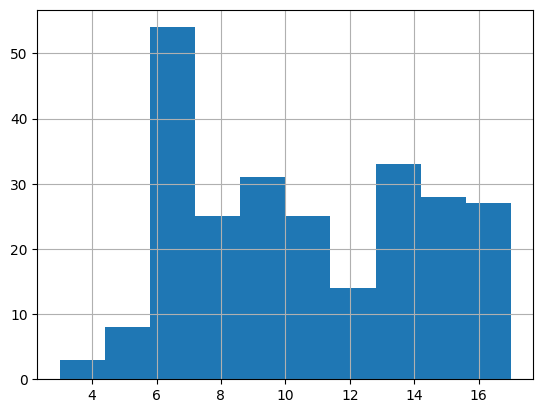

In [12]:
n_visits = clinical['patient_id'].value_counts()
n_patients = len(clinical['patient_id'].unique())
print(f'Number of patients: {n_patients}')
print(f'Number of visits per patient: {n_visits.min()} to {n_visits.max()}')
n_visits.hist()

n_proteins = len(prot_pivot.columns)

In [13]:
# join dataframes
data = prot_pivot.join(clin_pivot, on='visit_id')

In [14]:
data['patient_id'] = data.index.to_series().str.split('_', expand=True)[0].values.astype(int)
data['visit_month'] = data.index.to_series().str.split('_', expand=True)[1].values.astype(int)

# sort first by patient_id, then by visit_month
data = data.sort_values(by=['patient_id', 'visit_month'], inplace=False)

# save list of sequences

In [29]:
import torch

ids = data['patient_id'].unique()

data_dict = {'ids':ids, 'sequences':[], 'targets':[]}

for id in ids:
    # get all visits for this patient
    patient_data = data.loc[data['patient_id'] == id, :]
    
    # get all protein sequences for this patient
    patient_sequences = torch.Tensor(patient_data.loc[:, :'Q9Y6R7'].values)
    
    # get all UPDRS scores for this patient
    patient_targets = torch.Tensor(patient_data.loc[:, 'updrs_1':'updrs_4'].values)
    patient_targets[np.isnan(patient_targets)] = 0
    
    # add to data dictionary
    data_dict['sequences'].append(patient_sequences)
    data_dict['targets'].append(patient_targets)

/var/folders/nq/bz1rt70n33n4xgr93lwcs59w0000gn/T/ipykernel_97419/2332852523.py:16: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1647.)
  patient_targets[np.isnan(patient_targets)] = 0


In [30]:
np.save('./data/data_dict.npy', data_dict)

# pad sequences

In [ ]:
X = -np.ones((n_patients, n_visits.max(), n_proteins)) # -1 corresponds to missing values
Y = np.zeros((n_patients, n_visits.max(), 4))

ids = data['patient_id'].values
ids_unique = np.unique(ids)
seq_len = []

for i, id in enumerate(ids_unique):
    n = (data['patient_id'] == id).sum()
    seq_len.append(n)
    X[i, :n, :] = data.loc[ids == id, :'Q9Y6R7'].values
    Y[i, :n, :] = data.loc[ids == id, 'updrs_1':'updrs_4'].values

In [ ]:
# replace missing target values with zeros
Y[np.isnan(Y)] = 0

In [ ]:
# created padded tensor
import torch
import torch.nn.utils as utils

X_packed = utils.rnn.pack_padded_sequence(torch.Tensor(X), lengths=seq_len, batch_first=True, enforce_sorted=False)

In [ ]:
torch.save(X_packed, './data/X_packed.pt')
torch.save(Y, './data/Y_packed.pt')